# Gaussian Naive Bayes

## 1. Import Libraries and Setup

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

# set random seed
np.random.seed(42)

## 2. Load Dataset

In [3]:
# Load the dataset
df = pd.read_csv('churn_data_cleaned.csv')

## 3. Prepare Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class distribution.

In [4]:
# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

## 4. Define Hyperparameter Grid

Set up the parameter combinations to test using GridSearchCV. For Gaussian Naive Bayes, we tune the variance smoothing parameter and use StandardScaler for feature normalization.

In [5]:
# Import cross-validation tools
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("Setting up hyperparameter grid for Gaussian Naive Bayes")

# Define the parameter grid
param_grid = {
    'nb__var_smoothing': np.logspace(-12, -6, 20)
}

print(f"\nTotal combinations to test: {len(param_grid['nb__var_smoothing'])}")

Setting up hyperparameter grid for Gaussian Naive Bayes

Total combinations to test: 20


## 5. Perform 5-Fold Cross-Validation

Train the Gaussian Naive Bayes model using 5-fold cross-validation with grid search. We use a pipeline with StandardScaler to normalize features before training.

In [6]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create pipeline with StandardScaler and GaussianNB
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

# Set up GridSearchCV with Precision as the metric
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

print("Grid search complete.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ............................nb__var_smoothing=1e-12; total time=   0.2s
[CV] END ............................nb__var_smoothing=1e-12; total time=   0.2s
[CV] END ............................nb__var_smoothing=1e-12; total time=   0.3s
[CV] END ............................nb__var_smoothing=1e-12; total time=   0.3s
[CV] END ............................nb__var_smoothing=1e-12; total time=   0.4s
[CV] END .............nb__var_smoothing=2.06913808111479e-12; total time=   0.5s
[CV] END .............nb__var_smoothing=2.06913808111479e-12; total time=   0.6s
[CV] END .............nb__var_smoothing=2.06913808111479e-12; total time=   0.7s
[CV] END ............nb__var_smoothing=4.281332398719396e-12; total time=   0.7s
[CV] END .............nb__var_smoothing=2.06913808111479e-12; total time=   0.6s
[CV] END .............nb__var_smoothing=2.06913808111479e-12; total time=   0.5s
[CV] END ............nb__var_smoothing=4.281332

## 6. Display Cross-Validation Results

Show the best parameters found and the top 5 parameter combinations based on precision score.

In [7]:
# Display best parameters and cross-validation results
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

# Display top 5 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score']
]

print("\nTop 5 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"  Parameters: {row['params']}")
    print(f"  CV Precision Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Precision Score: {row['mean_train_score']:.4f}")
    print("\n")


Best Parameters Found:
  nb__var_smoothing: 1e-12

Best Cross-Validation Precision Score: 0.1380

Top 5 Parameter Combinations:
  Parameters: {'nb__var_smoothing': np.float64(1e-12)}
  CV Precision Score: 0.1380 (+/- 0.0018)
  Train Precision Score: 0.1379


  Parameters: {'nb__var_smoothing': np.float64(2.3357214690901212e-07)}
  CV Precision Score: 0.1380 (+/- 0.0018)
  Train Precision Score: 0.1379


  Parameters: {'nb__var_smoothing': np.float64(1.1288378916846883e-07)}
  CV Precision Score: 0.1380 (+/- 0.0018)
  Train Precision Score: 0.1379


  Parameters: {'nb__var_smoothing': np.float64(5.4555947811685146e-08)}
  CV Precision Score: 0.1380 (+/- 0.0018)
  Train Precision Score: 0.1379


  Parameters: {'nb__var_smoothing': np.float64(2.6366508987303555e-08)}
  CV Precision Score: 0.1380 (+/- 0.0018)
  Train Precision Score: 0.1379




## 7. Extract Final Model

Retrieve the best model from grid search, already trained with optimal parameters.

In [8]:
# Get the best model from grid search
nb_model = grid_search.best_estimator_

print(f"var_smoothing: {nb_model.named_steps['nb'].var_smoothing}")
print(f"Number of features: {nb_model.named_steps['nb'].n_features_in_}")

var_smoothing: 1e-12
Number of features: 30


## 8. Evaluate Model Performance

Make predictions on the test set and calculate performance metrics.

In [9]:
# Make predictions on test set
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\nGaussian Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Calculate individual metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_roc:.4f}")


Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.70      0.80     65253
       Churn       0.14      0.54      0.22      5785

    accuracy                           0.68     71038
   macro avg       0.54      0.62      0.51     71038
weighted avg       0.88      0.68      0.75     71038

Performance Metrics
Precision:  0.1365
Recall:     0.5428
F1 Score:   0.2182
AUC-ROC:    0.6627


## 9. Visualize Results

Plot confusion matrix and ROC curve to visualize model performance.

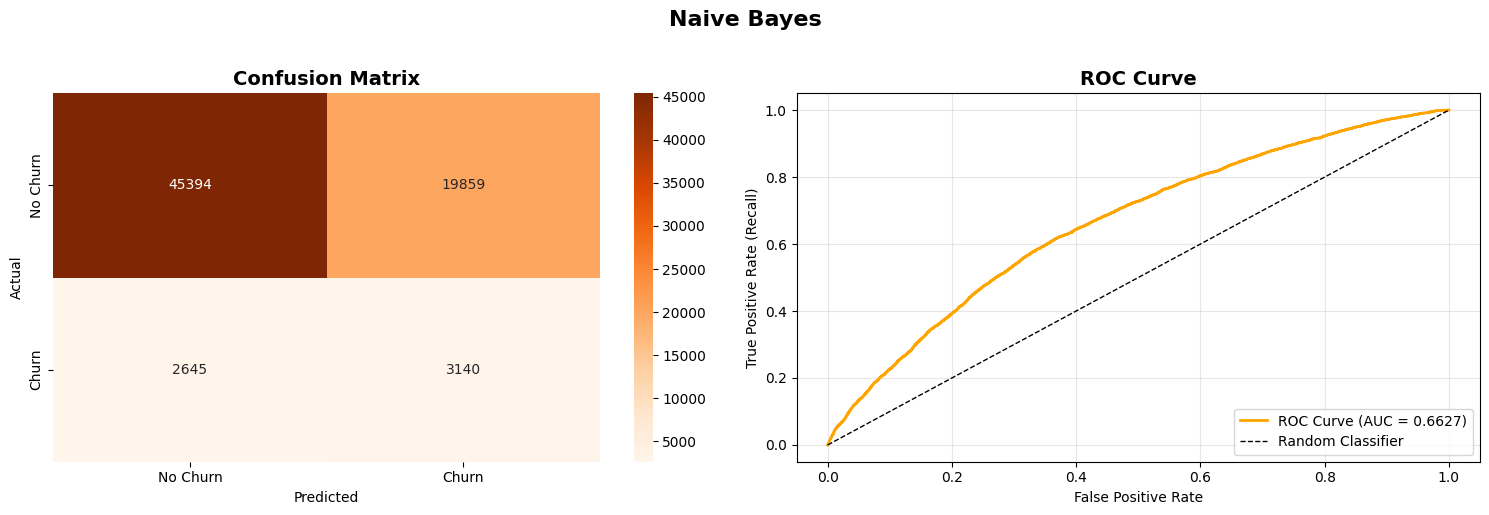

In [10]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Naive Bayes', fontsize=16, fontweight='bold', y=1.02)
 
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})', color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()